## Building a Recommendation System

*Notebook created by Gustavo R. Santos using the Grocery and Groumet Food ratings only Database by Amazon available on http://jmcauley.ucsd.edu/data/amazon/* 

In this project, our goal is to create a recommendation system that will give us the *n* recommended products to a given user

### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

### Loading the Dataset

In [2]:
# Loading CSV file
df = pd.read_csv('ratings_Grocery_and_Gourmet_Food.csv', header=None, names = ['user_id','prod_id','rating', 'timestamp'])

In [4]:
# First look at the dataset
df.head(4)

,user_id,prod_id,rating,timestamp
0,A1ZQZ8RJS1XVTX,0657745316,5.0,1381449600
1,A31W38VGZAUUM4,0700026444,5.0,1354752000
2,A3I0AV0UJX5OH0,1403796890,1.0,1385942400
3,A3QAAOLIXKV383,1403796890,3.0,1307836800


In [3]:
# Drop timestamp columns, as it will not be used in this study
df.drop('timestamp',axis=1, inplace=True)

### Data Exploratory Analysis

In [6]:
# Shape of the dataset
df.shape

(1297156, 3)

In [7]:
# Descriptive statistics
df.describe(include='all')

,user_id,prod_id,rating
count,1297156,1297156,1.297156e+06
unique,768438,166049,NaN
top,AY12DBB0U420B,B0051SU0OW,NaN
freq,518,6340,NaN
mean,NaN,NaN,4.254563e+00
std,NaN,NaN,1.253953e+00
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,4.000000e+00
50%,NaN,NaN,5.000000e+00
75%,NaN,NaN,5.000000e+00


Comments on the description:
* The user ID that appears the most is AY12DBB0U420B - 518 times
* Product B0051SU0OW is the most frequently reviewed - 6340 times
* Ratings mean is 4.25, what shows us those are skewed towards the positive ratings
* Standard deviation is 1.25, what gives us the range of 3 - 5 for most of the grades.

In [8]:
# Checking up for missing entries
df.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

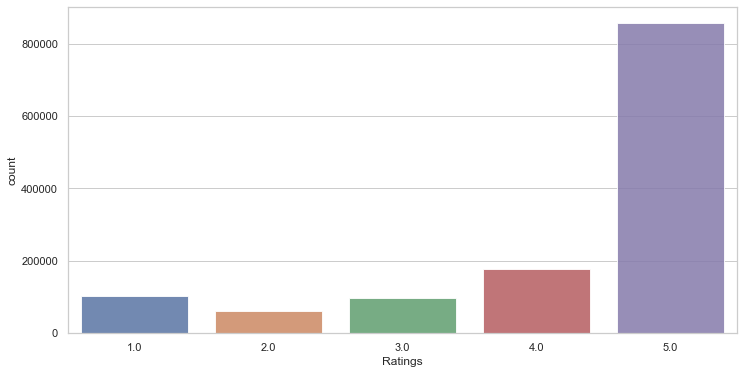

In [9]:
# Histogram
plt.figure(figsize=(12,6))
sns.countplot('rating', data=df, alpha=0.85)
plt.xlabel('Ratings', size=12)
plt.show()

Confirming our statistics, the ratings are heavily skewed towards 5.

In [10]:
print(f'Total Number of Ratings: {len(df)} \nTotal Number of Users: {len(df.user_id.unique())} \
\nAverage Number of Ratings by User: {round(len(df)/len(df.user_id.unique()),2)}')

Total Number of Ratings: 1297156 
Total Number of Users: 768438 
Average Number of Ratings by User: 1.69


The average is 1.7 products reviewed by client, but we know that is usually not true, since there are a few clients who rate hundreds of products and many who don't rate any product.

### Data Visualization

In [7]:
# Let's see the users that rated more
more = df.groupby('user_id').rating.count().sort_values(ascending=False)

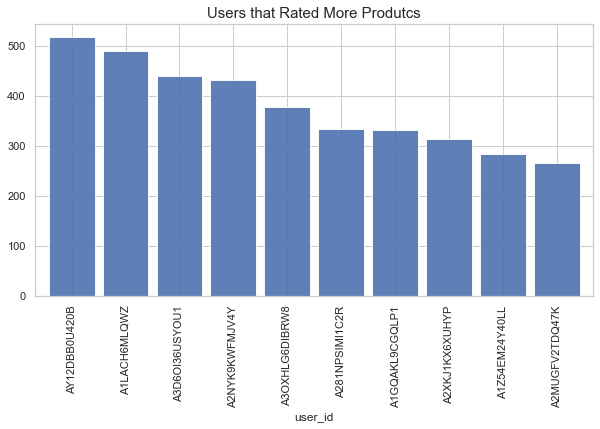

In [12]:
# Plotting the top 10 raters
plt.figure(figsize=(10,5))
more.head(10).plot(kind='bar', alpha=0.9, width=0.85)
plt.title("Users that Rated More Produtcs", size=15)
plt.show()

In [13]:
# Creating a set of quantiles from 0 to 100% with 1% step
quantiles = more.quantile(np.arange(0,1.01,0.01), interpolation='higher')

#quantiles Log scale
quantiles_log = np.log(quantiles)

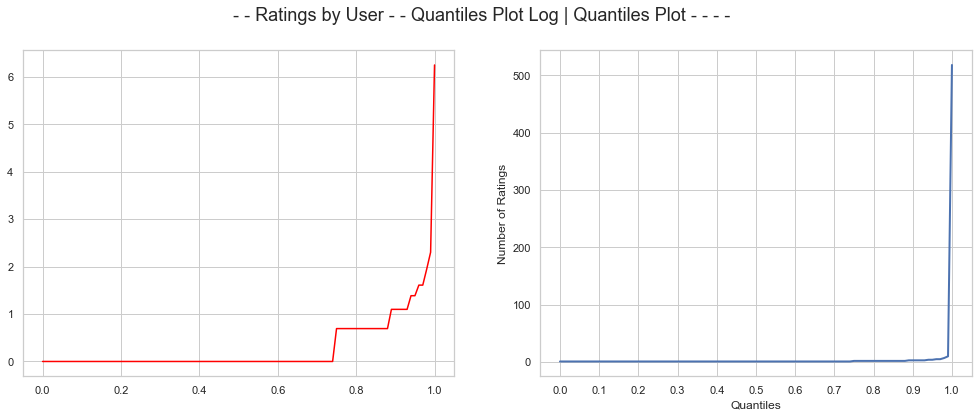

In [14]:
# Plot of the quantiles
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,6))
ax1.plot(quantiles_log, c='red')
ax2.plot(quantiles, linewidth=2)
fig.suptitle('- - Ratings by User - - Quantiles Plot Log | Quantiles Plot - - - -', size=18)
plt.xlabel('Quantiles')
plt.ylabel('Number of Ratings')
plt.xticks(np.arange(0.,1.01, 0.1))
plt.show()

From the plot above, we can see that 75% of the users didn't rate any product. Then it starts to grow a lot in the 99% quantile. 

In [22]:
# Quantity of users that rated more than 50 products
print(f'Rated 50 or more products: {sum(more>=50)}')
print(f'Rated more than 50 products: {sum(more>50)}')

Rated 50 or more products: 474
Rated more than 50 products: 459


### Popularity Based Recommender

The simplest recommendation system to be built is one based on popularity, or in other words, you will just calculate the quantities of reviews and the average of each item and will calculate a ranking based on that.
The problem is that it does not allow you any kind of personalization.

In [4]:
# Dataframe with products that have more than 50 rates
new_df=df.groupby("prod_id").filter(lambda x:x['rating'].count() >=50)

In [17]:
new_df.head()

,user_id,prod_id,rating
51,A36WJI0C99GC0Y,616719923X,4.0
52,A2CV5SDHJEMFQL,616719923X,5.0
53,A1QZDDMXSTNZN8,616719923X,3.0
54,AG0GO069IUZY1,616719923X,5.0
55,A2AW6171Q8A4LY,616719923X,5.0


In [26]:
# Creating a new DataFrame with mean rating and number of ratings by product
ratings_df = pd.DataFrame(new_df.groupby('prod_id').rating.mean())

In [27]:
# Adding column with number of ratings by product
ratings_df['rating_counts'] = new_df.groupby('prod_id').rating.count()

In [28]:
# Visualizing the 5 top rated products (number of ratings)
ratings_df.sort_values(by='rating_counts', ascending=False).head(5)

,rating,rating_counts
prod_id,,
B0051SU0OW,4.135016,6340
B00DS842HS,4.788815,3755
B000E1D7RS,4.504513,3102
B0029XDZIK,4.444371,3011
B005K4Q1YA,4.163000,3000


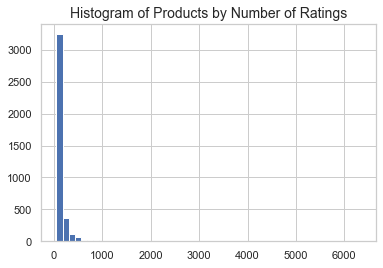

In [21]:
# Plot Histogram of the counts
ratings_df.rating_counts.hist(bins=50)
plt.title('Histogram of Products by Number of Ratings', size=14)
plt.show()

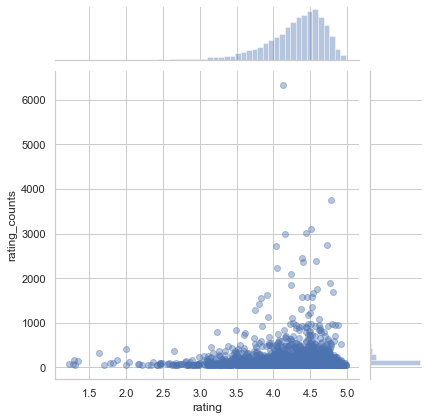

In [22]:
# Scatter plot of the ratings vs. counts
sns.jointplot(x='rating', y='rating_counts', data=ratings_df, alpha=0.4)
plt.show()

Here we can see - once again - that the ratings are concentrated around the 3-5.

Now what we're going to do is to calculate the global average. We already have the miminum votes necessary to be eligible for the popularity recommender, that is 50 votes.

After that, we will define a function to calculate an weighted average that takes the total number of votes and the threshold (50) and multiply it by the global average and by the average of the product. The formula is:
(v/(v+m) * R) + (m/(m+v) * C)

- v is the number of votes for the product;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the product;
- C is the mean vote across the whole report

In [23]:
# The global average of the ratings
C = ratings_df['rating'].mean()
print(round(C,2))

4.28


In [24]:
# Use the minimum number of votes required to be in the popularity recommender
m = ratings_df.rating_counts.min(); m

50

In [25]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['rating_counts']
    R = x['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [26]:
# Add the calculated 'score' with weighted_rating() to the dataframe
ratings_df['score'] = ratings_df.apply(weighted_rating, axis=1)

In [27]:
# Final result with the top 15 most popular products
ratings_df.sort_values(by='score', ascending=False).head(15)

,rating,rating_counts,score
prod_id,,,
B003EJ9KLO,4.911488,531,4.857077
B000NMJWZO,4.880083,959,4.850309
B003KRHDMI,4.837185,952,4.809343
B003QDRJXY,4.842857,700,4.805283
B00BI8OG2Q,4.803318,1688,4.788241
B00DS842HS,4.788815,3755,4.782119
B00HK6FGIS,4.822034,590,4.779628
B000GAT6NG,4.801839,979,4.776445
B005EL6VOY,4.918750,160,4.766486


## Collaberative filtering (Item-Item recommedation)

The collaborative filtering models start from the idea that people who think alike or products that are similar tend to give or receive similar rates. We also know that usually a person does not rate every product. One will rate a few products. But when a person rates a couple of products with similar grades to another, we can assume that they have similar likes and then, based on that assumption, we can predict the grades that are missing for another similar user, thus completing the missing values in the matrix.

In other words, we will transform each people's likes and dislikes in vectors of numbers and compare the angle between those vectors. The lower the angle, more similar they are and the opposite is also true, the higher the angle, they tend to be more different.

In [129]:
# Imports
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD

In [130]:
# Reading the dataset from Pandas using surprise's Reader function, which will parse the file to adjust to be used by the Surprise package
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [131]:
# Splitting the dataset
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [132]:
# Creating a model item-based (user_based true/false to switch between user-based or item-based collaborative filtering)
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [133]:
# Testing the model
test_pred = algo.test(testset)

In [134]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1980


1.1980300994501594

In [148]:
# Using the get_neighbors function to get the 10 recommendations for product on index 1 from the ratings_df = 9742356831
algo.get_neighbors(1, 10)

[2, 12, 17, 24, 30, 34, 35, 36, 42, 60]

In [158]:
# Here are the 10 recommended product names
ratings_df.iloc[[2, 12, 17, 24, 30, 34, 35, 36, 42, 60]].index

Index(['B0000531B7', 'B0000CF8T1', 'B0000DC2VI', 'B0000DJT3C', 'B0000T71C6',
       'B000100EQ4', 'B00012182G', 'B00014CZP8', 'B00014FT06', 'B00017LEXO'],
      dtype='object', name='prod_id')

## Model-based collaborative filtering system

Finally, a more complex model that is the Matrix Factorization, taking into consideration the user name and product id to make the predictions.

In [82]:
# Let's work with 50k rows for computational reason 
new_df1=new_df.head(50000)
ratings_matrix = new_df1.pivot_table(values='rating', index='user_id', columns='prod_id', fill_value=0)
ratings_matrix.head()

prod_id,616719923X,9742356831,B0000531B7,B00005344V,B0000537AF,B00005C2M2,B000063D0D,B00006G92S,B00006IUTN,B0000CD06J,...,B000E63LME,B000E63LOM,B000E63LQU,B000E65OF6,B000E65OII,B000E65OJM,B000E65OJW,B000E65OK6,B000E65OKQ,B000E65OQA
user_id,,,,,,,,,,,,,,,,,,,,,
A0004478EF5NFPHLGCWG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0009478CBXKUCALUC7U,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0010028HGBTWSS5F8J6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00635603LUUJQPQWSJW1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00785113MS6AJL3V9JOR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
ratings_matrix.shape

(46678, 348)

In [84]:
# Transposing the matrix
X = ratings_matrix.T
X.head()

user_id,A0004478EF5NFPHLGCWG,A0009478CBXKUCALUC7U,A0010028HGBTWSS5F8J6,A00635603LUUJQPQWSJW1,A00785113MS6AJL3V9JOR,A0143870M4QGI22E43RR,A0175186TQSOXAMVZ3IO,A021874321O48MHLE22YG,A025365536J4VIIEA7QWY,A0292298NUG76VEK5G3J,...,AZZ6UOWM411JM,AZZH3GGYQSBUC,AZZHZZMH3U1VB,AZZIEVSDLDBUK,AZZK743T5BH3T,AZZKE6QEJ2RQ2,AZZNK89PXD006,AZZSJZ0CWCMTL,AZZV61COVM8CA,AZZXT5AZPVZBL
prod_id,,,,,,,,,,,,,,,,,,,,,
616719923X,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
9742356831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000531B7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00005344V,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B0000537AF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
X.shape

(348, 46678)

In [177]:
#Decomposing the Matrix.
#The Truncated SVD function will actually reduce the dimension of the sparse matrix into the number of components requested 
SVD_model = TruncatedSVD(n_components=10)
decomposed_matrix = SVD_model.fit_transform(X)
decomposed_matrix.shape

(348, 10)

In [88]:
#Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(348, 348)

Now I have just created a correlation matrix out of the decomposed matrix. This means that, for each user I will calculate how similar he is to the other users. The more it goes towards 1, more similar and going to -1, more different.

In [92]:
correlation_matrix

array([[ 1.        ,  0.86825074,  0.19663589, ..., -0.29780345,
        -0.3129282 , -0.53077435],
       [ 0.86825074,  1.        ,  0.43560749, ...,  0.00273403,
        -0.39470035, -0.47619452],
       [ 0.19663589,  0.43560749,  1.        , ...,  0.30518534,
         0.24253142,  0.26686407],
       ...,
       [-0.29780345,  0.00273403,  0.30518534, ...,  1.        ,
        -0.12371912,  0.00496465],
       [-0.3129282 , -0.39470035,  0.24253142, ..., -0.12371912,
         1.        ,  0.64878579],
       [-0.53077435, -0.47619452,  0.26686407, ...,  0.00496465,
         0.64878579,  1.        ]])

In [91]:
# Choosing a product from the list to get the recommendations for. I have chosen the same as the Item-based recommender.
i = "9742356831"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

1

In [93]:
# Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(348,)

In [108]:
# Top 10 products similar to product 9742356831 recommended for this user.
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:10]

['616719923X',
 'B0000CF8T1',
 'B0000DC2VI',
 'B0000V8IOE',
 'B00015UC4I',
 'B00015UC4S',
 'B0001AO8DY',
 'B0001CXUHW',
 'B0001M0Z6Q',
 'B00021639Y']

In [163]:
# Both model's recommendations
item_based = ['B0000531B7','B0000CF8T1','B0000DC2VI','B0000DJT3C','B0000T71C6','B000100EQ4','B00012182G','B00014CZP8','B00014FT06','B00017LEXO']
SVD_model_res = ['616719923X', 'B0000CF8T1', 'B0000DC2VI', 'B0000V8IOE', 'B00015UC4I', 'B00015UC4S', 'B0001AO8DY', 'B0001CXUHW', 'B0001M0Z6Q','B00021639Y']

In [164]:
# How many overlaps between both models
c = 0
for i in item_based:
    if i in SVD_model_res:
        c +=1

c

2

### Another way of using the Matrix Factorization (SVD algorithm)

In [169]:
from surprise import SVD
from surprise.model_selection import cross_validate, KFold
%matplotlib inline

Imports successful!


In [170]:
model_matrix = SVD()

In [171]:
model_matrix_results = cross_validate(model_matrix, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1286  1.1279  1.1278  1.1341  1.1294  1.1296  0.0023  
Fit time          26.02   27.63   28.46   28.77   27.98   27.77   0.96    
Test time         0.72    0.73    1.62    1.49    0.74    1.06    0.41    


In [210]:
# Using the get top N function from the Surprise documentation
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = dict()
    for uid, iid, true_r, est, _ in predictions:
        current = top_n.get(uid, [])
        current.append((iid, est))
        top_n[uid] = current

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [211]:
models = [model_matrix, algo]
model_names = ['Matrix Factorization', 'Item-Based']

for i, model in enumerate(models):
    model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print one line
    user = list(top_n.keys())[14]
    print('- ' *10)
    print(f'model name: {model_names[i]}')
    print(f'user ID: {user}')
    print(f'top 5 products ID\'s this user would like, sorted by rating highest to lowest: {top_n[user]}')



- - - - - - - - - - 
model name: Matrix Factorization
user ID: A2MSQNPTNAAGL1
top 5 products ID's this user would like, sorted by rating highest to lowest: [('B0005ZVOR8', 4.668220732150213), ('B002TMV3GC', 4.232921119893836), ('B003VSFELS', 4.221182390968603), ('B000HQL2JA', 4.1919264133940555), ('B005VOOOM0', 4.169132341534536)]
Computing the msd similarity matrix...
Done computing similarity matrix.
- - - - - - - - - - 
model name: Item-Based
user ID: A2MSQNPTNAAGL1
top 5 products ID's this user would like, sorted by rating highest to lowest: [('B0005ZVOR8', 5), ('B001IZM92S', 5), ('B000SATIE6', 4.8873962924574315), ('B004MO6NI8', 4.590729524406541), ('B002TMV3GC', 4.554783954795987)]


.

Like the TruncatedSVD model, this one has 2 overlaps too between the Item-based and SVD.

### The End